In [211]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import numpy as np
import operator
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy import polyfit, polyval
%matplotlib inline

Does the total transportation volume ( 1) uber+taxi pickups+subway entrances, 2)  uber+taxi dropoffs+subway exits ) stay approximately the same for each of the five boroughs? How does the shares of UBER, taxi (green+yellow) and subway change within this total? Perhaps we can start from plotting 5 borough timelines (for pick ups/entrances and drop offs/exits separately) with a cumulative daily count changing over the last 2 years (let’s put the months in order to get an idea of seasonality and show the UBER pool launch with a vertical line) and showing the fraction of UBER, taxi and subway with different colors within this total. If subway share will be too overwhelmingly large, could make sense to show it separately for UBER+taxi.

In [127]:
taxi_zones = gpd.read_file("../../Data/taxi_zones_manhattan/tzones_man.shp")

In [128]:
yp = pd.read_csv("../../Data/Aggregated/yellow_pickup.csv")
yp.drop(['Unnamed: 0'], axis=1, inplace=True)
yp.date = pd.to_datetime(yp.date)

In [129]:
gp = pd.read_csv("../../Data/Aggregated/green_pickup.csv")
gp.drop(['Unnamed: 0'], axis=1, inplace=True)
gp.date = pd.to_datetime(gp.date)

In [130]:
uber = pd.read_csv("../../Data/Aggregated/uber.csv")
uber.drop(['Unnamed: 0'], axis=1, inplace=True)

In [131]:
uber.Date = pd.to_datetime(uber.Date)

In [132]:
subway = pd.read_csv("../../Data/Aggregated/subways.csv")
subway.DATE = pd.to_datetime(subway.DATE)

In [133]:
boro = taxi_zones[['LocationID', 'borough']]

In [134]:
uber.columns

Index([u'Date', u'LocationID', u'counts'], dtype='object')

In [135]:
yp = pd.merge(yp, boro, how='inner', left_on='locationid', right_on='LocationID')

In [136]:
gp = pd.merge(gp, boro, how='inner', left_on='locationid', right_on='LocationID')

In [137]:
uber = pd.merge(uber, boro, how='inner', left_on='LocationID', right_on='LocationID')

In [138]:
subway = pd.merge(subway, boro, how='inner', left_on='LocationID', right_on='LocationID')

In [139]:
uber_pre = uber[uber.Date < '2015-01-01']
uber_post = uber[uber.Date >= '2015-01-01']

# Manhattan

In [142]:
yp_man_loc = yp[(yp.borough == 'Manhattan') ]

In [143]:
yp_man_loc = yp_man_loc.set_index('date')

In [144]:
yp_man_loc.head(2)

,locationid,trip_distance,pickup_count,LocationID,borough
date,,,,,
2013-01-01,4,3.238300,2059,4,Manhattan
2013-01-02,4,2.670426,1079,4,Manhattan


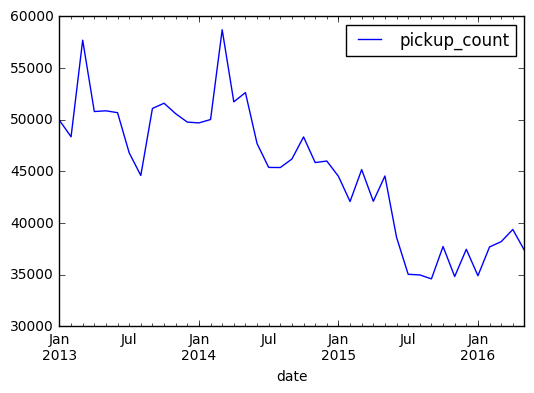

In [145]:
yp_man_loc[yp_man_loc.locationid == 4].groupby([pd.TimeGrouper('M')]).agg({'pickup_count':'sum'}).plot()

In [82]:
gp_man_loc = gp[(gp.borough == 'Manhattan') ]

In [83]:
gp_man_loc = gp_man_loc.set_index('date')

In [84]:
gp_man_loc.head(2)

,locationid,trip_distance,pickup_count,LocationID,borough
date,,,,,
2014-01-01,24,3.044286,28,24,Manhattan
2014-01-02,24,2.510000,28,24,Manhattan


In [85]:
green_man = gp_man_loc[gp_man_loc.locationid == 4].groupby([pd.TimeGrouper('M')]).agg({'pickup_count':'sum'})

In [86]:
subway_man_loc = subway[subway.borough == 'Manhattan']
subway_man_loc = subway_man_loc.set_index('DATE')

In [87]:
subway_man_loc.head(2)

,LocationID,EXITS_DIFF,ENTRIES_DIFF,borough
DATE,,,,
2014-10-11,24,3917.0,9838.0,Manhattan
2014-10-12,24,4446.0,9607.0,Manhattan


In [88]:
uber_pre_man_loc = uber_pre[uber_pre.borough == 'Manhattan']
uber_post_man_loc = uber_post[uber_post.borough == 'Manhattan']

In [89]:
uber_pre_man_loc = uber_pre_man_loc.set_index('Date')
uber_post_man_loc = uber_post_man_loc.set_index('Date')

In [90]:
uber_pre_man_loc.head(2)

,LocationID,counts,borough
Date,,,
2014-04-01,4,81,Manhattan
2014-04-02,4,77,Manhattan


In [91]:
uber_post_man_loc.head(2)

,LocationID,counts,borough
Date,,,
2015-01-01,4,480,Manhattan
2015-01-02,4,317,Manhattan


In [92]:
yp_man_loc.locationid.unique()

array([  4,  12,  13,  24,  41,  43,  45,  48,  50,  68,  74,  75,  79,
        87,  88,  90, 100, 105, 107, 113, 114, 125, 137, 140, 141, 142,
       143, 144, 148, 151, 158, 161, 162, 163, 164, 166, 170, 186, 194,
       202, 209, 211, 224, 229, 230, 231, 232, 233, 234, 236, 237, 238,
       239, 246, 249, 261, 262, 263, 104, 103])

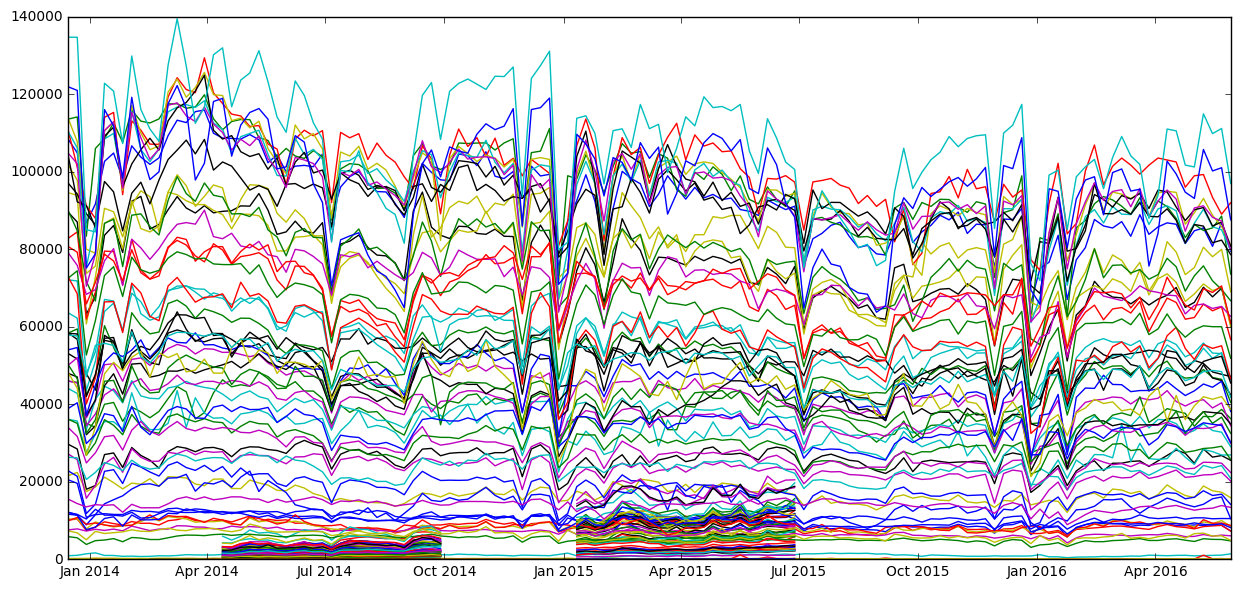

In [34]:
plt.figure(figsize=(15,7))
for loc in yp_man_loc.locationid.unique():
    
    uber_pre_man = uber_pre_man_loc[uber_pre_man_loc.LocationID == loc].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
    uber_post_man = uber_post_man_loc[uber_post_man_loc.LocationID == loc].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
    yellow_man = yp_man_loc[yp_man_loc.locationid == loc].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]

    plt.plot(yellow_man.index, yellow_man.pickup_count)
    plt.plot(uber_pre_man.index, uber_pre_man.counts)
    plt.plot(uber_post_man.index, uber_post_man.counts)
# plt.plot(green_man.index, green_man.pickup_count)

# Yellow Pickup

In [93]:
top_locs = {}
for loc in yp_man_loc.locationid.unique():     
    
    top_locs[loc] = ((yp_man_loc[yp_man_loc.locationid == loc].pickup_count[0:100].sum() *1.0) / 
                      yp_man_loc[yp_man_loc.locationid == loc].pickup_count[-100:].sum())

print "Location with most change in pickups of yellow cabs:"    
sorted(top_locs.items(), key=operator.itemgetter(1), reverse=True)[:20]

Location with most change in pickups of yellow cabs:


[(202, 2.2998204667863553),
 (166, 1.762587260466312),
 (105, 1.5317460317460319),
 (211, 1.5115437634200404),
 (125, 1.5063904066700406),
 (75, 1.4499601567709095),
 (158, 1.3942805992650522),
 (4, 1.3779453195031375),
 (144, 1.3697196371281861),
 (233, 1.359953322245131),
 (230, 1.3583671575264948),
 (45, 1.3443569021291943),
 (224, 1.3439876242957856),
 (107, 1.3415016870850316),
 (229, 1.3404935971367959),
 (249, 1.3385245611760128),
 (50, 1.3313455575134079),
 (113, 1.3308169294088412),
 (79, 1.3187129288684107),
 (143, 1.31503392365016)]

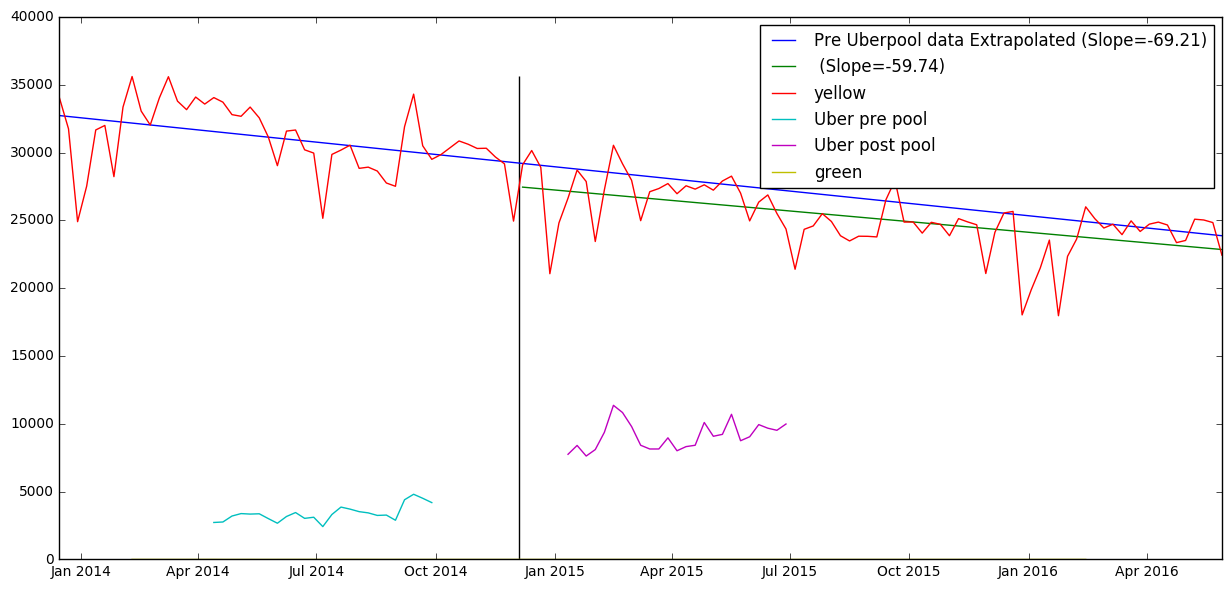

In [36]:
uber_pre_man = uber_pre_man_loc[uber_pre_man_loc.LocationID == 211].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
uber_post_man = uber_post_man_loc[uber_post_man_loc.LocationID == 211].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
yellow_man = yp_man_loc[yp_man_loc.locationid == 211].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
green_man = gp_man_loc[gp_man_loc.locationid == 211].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
# subway_man = subway_man_loc[subway_man_loc.LocationID == 202].groupby([pd.TimeGrouper('W')]).agg({'ENTRIES_DIFF':'sum'})[1:-1]


a1,b1=polyfit(range(len(yellow_man[(yellow_man.index < '2014-12-04')])), 
              yellow_man[(yellow_man.index < '2014-12-04')].loc[:,'pickup_count'],1)
linreg1=polyval([a1,b1],range(len(yellow_man)))


a2,b2=polyfit(range(len(yellow_man[(yellow_man.index >= '2014-12-04') ])), 
              yellow_man[(yellow_man.index >= '2014-12-04')].loc[:,'pickup_count'],1)
linreg2=polyval([a2,b2],range(len(yellow_man[(yellow_man.index >= '2014-12-04')])))

plt.figure(figsize=(15,7))
plt.plot(yellow_man.index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
plt.plot(yellow_man[(yellow_man.index >= '2014-12-04')].index, linreg2, label = " (Slope="+str(round(a2,2))+")")


plt.plot(yellow_man.index, yellow_man.pickup_count, label = 'yellow')
plt.plot(uber_pre_man.index, uber_pre_man.counts, label = 'Uber pre pool')
plt.plot(uber_post_man.index, uber_post_man.counts, label = 'Uber post pool')
plt.plot(green_man.index, green_man.pickup_count, label = 'green')
plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yellow_man.pickup_count)+ 10)
# plt.plot(subway_man.index, subway_man.ENTRIES_DIFF)
plt.legend()

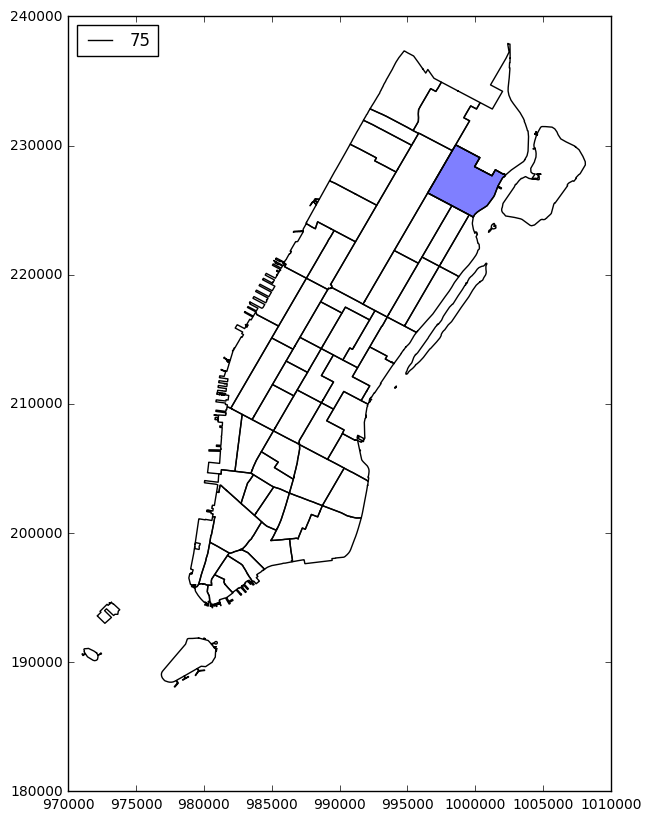

In [101]:
fig, ax = plt.subplots(1, figsize = (7,10))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax, color = 'white')
for loc in sorted(top_locs.items(), key=operator.itemgetter(1), reverse=True)[5:6]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax, color = 'blue', label = loc[0])
plt.legend(loc='best')

# Subway Entries

In [38]:
top_subway = {}
for loc in subway_man_loc.LocationID.unique():     
    
    top_subway[loc] = ((subway_man_loc[subway_man_loc.LocationID == loc].ENTRIES_DIFF[0:100].sum() *1.0) / 
                      subway_man_loc[subway_man_loc.LocationID == loc].ENTRIES_DIFF[-100:].sum())

print "Location with most change in pickups of subway entries:"    
sorted(top_subway.items(), key=operator.itemgetter(1), reverse=True)[:10]

Location with most change in pickups of subway entries:


[(161, 4.8117578502760177),
 (211, 1.9913700113195543),
 (230, 1.0563453089851935),
 (107, 1.0513032721834112),
 (229, 1.0323831532761645),
 (114, 1.0208740668105116),
 (68, 1.0192814064707332),
 (237, 1.0150426954703466),
 (239, 1.0130175790217553),
 (24, 0.99732985327071511)]

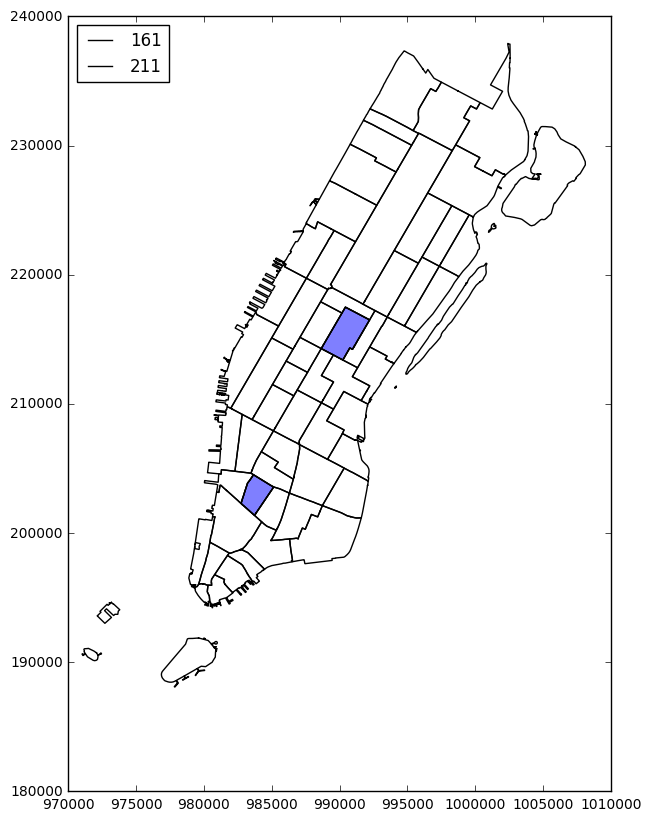

In [39]:
fig, ax = plt.subplots(1, figsize = (7,10))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax, color = 'white')

for loc in sorted(top_subway.items(), key=operator.itemgetter(1), reverse=True)[:2]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax, color = 'blue', label = loc[0])

plt.legend(loc='best')

# Uber pickups

In [ ]:
top_uber = {}
for loc in uber_man_loc.LocationID.unique():     
    
    top_uber[loc] = ((uber_man_loc[uber_man_loc.LocationID == loc].counts[-100:].sum() *1.0) / 
                        uber_man_loc[uber_man_loc.LocationID == loc].counts[0:100].sum())

print "Location with most change in pickups of uber:"    
sorted(top_uber.items(), key=operator.itemgetter(1), reverse=True)[:10]

In [ ]:
fig, ax = plt.subplots(1, figsize = (7,10))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax, color = 'white')
for loc in sorted(top_uber.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax, color = 'blue', label = loc[0])
    
plt.legend(loc='best')

# Green Pickups

In [ ]:
top_green = {}
for loc in gp_man_loc.locationid.unique():     
    
    top_green[loc] = ((gp_man_loc[gp_man_loc.LocationID == loc].pickup_count[200:400].sum() *1.0) / 
                        gp_man_loc[gp_man_loc.LocationID == loc].pickup_count[-100:].sum())

print "Location with most change in pickups of green cabs:"    
sorted(top_green.items(), key=operator.itemgetter(1), reverse=True)[:10]

In [ ]:
fig, ax = plt.subplots(1, figsize = (7,10))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax, color = 'white')
for loc in sorted(top_green.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax, color = 'blue', label = loc[0])
    
plt.legend(loc='best')

In [ ]:
uber_pre_man = uber_pre_man_loc[uber_pre_man_loc.LocationID == 127].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
uber_post_man = uber_post_man_loc[uber_post_man_loc.LocationID == 127].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
yellow_man = yp_man_loc[yp_man_loc.locationid == 127].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
green_man = gp_man_loc[gp_man_loc.locationid == 127].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
# subway_man = subway_man_loc[subway_man_loc.LocationID == 202].groupby([pd.TimeGrouper('W')]).agg({'ENTRIES_DIFF':'sum'})[1:-1]

plt.figure(figsize=(15,7))
plt.plot(yellow_man.index, yellow_man.pickup_count, label = 'yellow')
plt.plot(uber_pre_man.index, uber_pre_man.counts, label = 'Uber pre pool')
plt.plot(uber_post_man.index, uber_post_man.counts, label = 'Uber post pool')
plt.plot(green_man.index, green_man.pickup_count, label = 'green')
plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yellow_man.pickup_count)+ 10)
# plt.plot(subway_man.index, subway_man.ENTRIES_DIFF)
plt.legend()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,7))

taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax1, color = 'white')
taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax2, color = 'white')
taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax3, color = 'white')
taxi_zones[taxi_zones.borough == 'Manhattan'].plot(ax = ax4, color = 'white')

for loc in sorted(top_locs.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax1, color = 'blue', label = loc[0])
ax1.legend(loc='best')
ax1.set_title('Yellow pickups decrease')

for loc in sorted(top_uber.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax2, color = 'blue', label = loc[0])
ax2.legend(loc='best')
ax2.set_title('Uber pickups increase')

for loc in sorted(top_subway.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax3, color = 'blue', label = loc[0])
ax3.legend(loc='best')
ax3.set_title('Subway entries decrease')

for loc in sorted(top_green.items(), key=operator.itemgetter(1), reverse=True)[:10]:
    taxi_zones[taxi_zones.LocationID == loc[0]].plot(ax = ax4, color = 'blue', label = loc[0])
ax4.legend(loc='best')
ax4.set_title('green pickups decrease')

In [ ]:
uber_pre_man = uber_pre_man_loc[uber_pre_man_loc.LocationID == 166].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
uber_post_man = uber_post_man_loc[uber_post_man_loc.LocationID == 166].groupby([pd.TimeGrouper('W')]).agg({'counts':'sum'})[1:-1]
yellow_man = yp_man_loc[yp_man_loc.locationid == 166].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
green_man = gp_man_loc[gp_man_loc.locationid == 166].groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]
# subway_man = subway_man_loc[subway_man_loc.LocationID == 202].groupby([pd.TimeGrouper('W')]).agg({'ENTRIES_DIFF':'sum'})[1:-1]

plt.figure(figsize=(15,7))
plt.plot(yellow_man.index, yellow_man.pickup_count, label = 'yellow')
plt.plot(uber_pre_man.index, uber_pre_man.counts, label = 'Uber pre pool')
plt.plot(uber_post_man.index, uber_post_man.counts, label = 'Uber post pool')
plt.plot(green_man.index, green_man.pickup_count, label = 'green')
plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yellow_man.pickup_count)+ 10)
plt.title('Location 166')
# plt.plot(subway_man.index, subway_man.ENTRIES_DIFF)
plt.legend()

In [ ]:
yp_man = yp[yp.borough == 'Manhattan']
yp_man = yp_man.set_index('date').groupby([pd.TimeGrouper('D')]).agg({'pickup_count':'sum'})

gp_man = gp[gp.borough == 'Manhattan']
gp_man = gp_man.set_index('date').groupby([pd.TimeGrouper('D')]).agg({'pickup_count':'sum'})

In [ ]:
uber_man = uber[uber.borough == 'Manhattan']
uber_man = uber_man.set_index('Date').groupby([pd.TimeGrouper('D')]).agg({'counts':'sum'})

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
# gp_man.plot(ax=ax, label = 'Green Pickups')
# uber_man.rolling(window=10,center=False).mean().plot(ax=ax,label = 'Uber Pickups')


a1,b1=polyfit(range(len(yp_man[yp_man.index < '2014-12-04'])), 
              yp_man[yp_man.index < '2014-12-04'].loc[:,'pickup_count'],1)
linreg1=polyval([a1,b1],range(len(yp_man)))


a2,b2=polyfit(range(len(yp_man)), 
              yp_man.loc[:,'pickup_count'],1)
linreg2=polyval([a2,b2],range(len(yp_man)))

# ax.plot(yp_man.index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
# ax.plot(yp_man.index, linreg2, label = "Complete Data (Slope="+str(round(a2,2))+")")

yp_man.plot(ax=ax, label = 'Yellow Pickups')
plt.vlines(x='12-04-2014', ymin= 0, ymax= 600000)
plt.legend()




In [ ]:
# Fourier extrapolation
# Function to use fourier transform for predictions
def fourierExtrapolation(x, n_predict):
    n = len(x)
    # number of harmonics in model
    n_harm = 80             
    t = np.arange(0, n)
    # find linear trend in x
    p = np.polyfit(t, x, 1)         
    # remove the trend
    x_notrend = x - p[0] * t        
    # x with no trend in frequency domain
    x_freqdom = np.fft.fft(x_notrend)  
    # calculating frequencies
    f = np.fft.fftfreq(n)              
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda z: np.absolute(f[z]))
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        # get amplitude
        ampli = np.absolute(x_freqdom[i]) / n   
        # get phase
        phase = np.angle(x_freqdom[i])          
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [ ]:
# Predicting through extrapolation
n_predict = 545
extrapolation = fourierExtrapolation(yp_man[yp_man.index < '2014-12-04']['pickup_count'], n_predict)
# difference = highlinemean[:167] - extrapolation[:167]
# a1, b1=polyfit(range(56, 167), difference[56:], 1)
# linreg1=polyval([a1, b1], range(56, 167))

# # Plotting Chelsea extrapolated by Fourier
fig, ax = plt.subplots(figsize=(20,7))
ax.grid(True)
zlot1 = ax.plot(yp_man , linewidth = 1, label = 'Yellow Pickups True', color = "blue")
plot4 = ax.plot(yp_man.index, extrapolation[:], linewidth = 1.5, label = 'Yellow Pickups Extrapolated',
                ls = "--", color = "red")
plt.vlines(x='12-04-2014', ymin=  00, ymax= 600000)
plt.title('Fourier Extrapolation of Manhattan pickups', size = 22)
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
ax.grid(True)
# zlot1 = ax.plot(yp_man , linewidth = 1, label = 'CHELSEA TRUE', color = "blue")
plot4 = ax.plot(yp_man.index, extrapolation[:], linewidth = 1.5, label = 'CHELSEA EXTRAPOLATION',
                ls = "--", color = "red")
plt.vlines(x='12-04-2014', ymin=  00, ymax= 600000)
plt.title('Only Fourier Extrapolated time series( from dec 2014) for Manhattan', size = 22)

# Upper Manhattan

In [146]:
locs = [74,41,166,24,151,238,75, 236, 263, 262]

In [147]:
yp_upper_man = yp_man_loc[(yp_man_loc.locationid == 74) | (yp_man_loc.locationid == 41) | (yp_man_loc.locationid == 166) | 
           (yp_man_loc.locationid == 24) | (yp_man_loc.locationid == 151) | (yp_man_loc.locationid == 238) |
           (yp_man_loc.locationid == 75) | (yp_man_loc.locationid == 236) | (yp_man_loc.locationid == 263) |
           (yp_man_loc.locationid == 262)]

In [148]:
yp_upper_man = yp_upper_man.groupby([pd.TimeGrouper('W')]).agg({'pickup_count':'sum'})[1:-1]

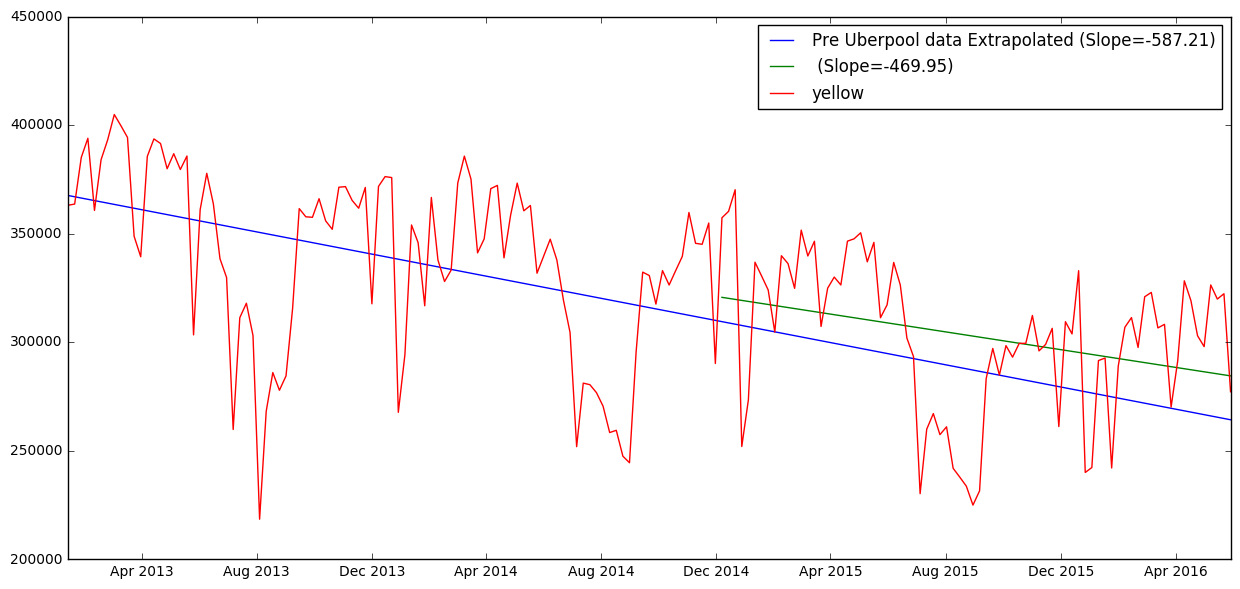

In [153]:
# fig, ax = plt.subplots(figsize=(12,5))

a1,b1=polyfit(range(len(yp_upper_man[yp_upper_man.index < '2014-12-04'])), 
              yp_upper_man[yp_upper_man.index < '2014-12-04'].loc[:,'pickup_count'],1)
linreg1=polyval([a1,b1],range(len(yp_upper_man)))


a2,b2=polyfit(range(len(yp_upper_man[yp_upper_man.index >= '2014-12-04'])), 
              yp_upper_man[yp_upper_man.index >= '2014-12-04'].loc[:,'pickup_count'],1)
linreg2=polyval([a2,b2],range(len(yp_upper_man[yp_upper_man.index >= '2014-12-04'])))

plt.figure(figsize=(15,7))
plt.plot(yp_upper_man.index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
plt.plot(yp_upper_man[(yp_upper_man.index >= '2014-12-04')].index, linreg2, label = " (Slope="+str(round(a2,2))+")")
plt.plot(yp_upper_man.index, yp_upper_man.pickup_count, label = 'yellow')
# plt.plot(uber_pre_man.index, uber_pre_man.counts, label = 'Uber pre pool')
# plt.plot(uber_post_man.index, uber_post_man.counts, label = 'Uber post pool')
# plt.plot(green_man.index, green_man.pickup_count, label = 'green')
# plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yellow_man.pickup_count)+ 10)

# yp_upper_man.plot(label = 'Yellow Pickups')
# plt.vlines(x='12-04-2014', ymin= 0, ymax= 600000)
plt.legend()


In [156]:
subway_man_loc.columns

Index([u'LocationID', u'EXITS_DIFF', u'ENTRIES_DIFF', u'borough'], dtype='object')

In [167]:
subway_man = subway_man_loc.groupby([pd.TimeGrouper('W')]).agg({'ENTRIES_DIFF':'sum'})[1:-1]

In [183]:
subway_man = subway_man[subway_man.ENTRIES_DIFF > subway_man.ENTRIES_DIFF.mean() - 3*subway_man.ENTRIES_DIFF.std()]

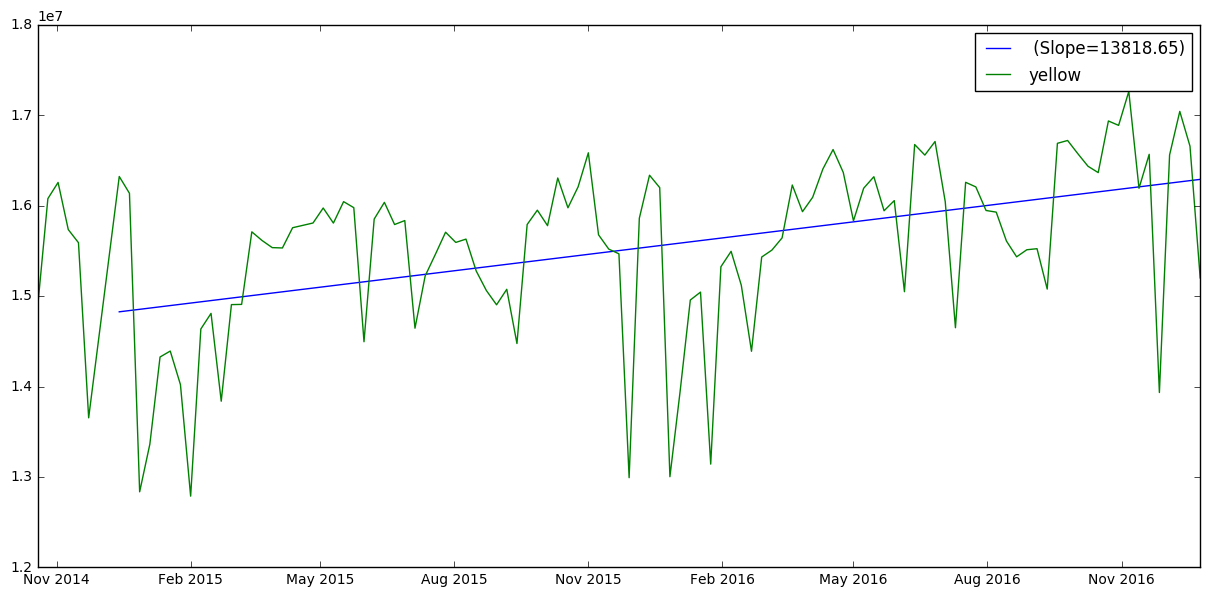

In [223]:
# fig, ax = plt.subplots(figsize=(12,5))

a1,b1=polyfit(range(len(subway_man[subway_man.index < '2014-12-04'])), 
              subway_man[subway_man.index < '2014-12-04'].loc[:,'ENTRIES_DIFF'],1)
linreg1=polyval([a1,b1],range(len(subway_man)))


a2,b2=polyfit(range(len(subway_man[subway_man.index >= '2014-12-04'])), 
              subway_man[subway_man.index >= '2014-12-04'].loc[:,'ENTRIES_DIFF'],1)
linreg2=polyval([a2,b2],range(len(subway_man[subway_man.index >= '2014-12-04'])))

plt.figure(figsize=(15,7))
# plt.plot(subway_man.index, linreg1, label = "Pre Uberpool data Extrapolated (Slope="+str(round(a1,2))+")")
plt.plot(subway_man[(subway_man.index >= '2014-12-04')].index, linreg2, label = " (Slope="+str(round(a2,2))+")")
plt.plot(subway_man.index, subway_man.ENTRIES_DIFF, label = 'yellow')
# plt.plot(uber_pre_man.index, uber_pre_man.counts, label = 'Uber pre pool')
# plt.plot(uber_post_man.index, uber_post_man.counts, label = 'Uber post pool')
# plt.plot(green_man.index, green_man.pickup_count, label = 'green')
# plt.vlines(x='12-04-2014', ymin= 0, ymax= max(yellow_man.pickup_count)+ 10)

# yp_upper_man.plot(label = 'Yellow Pickups')
# plt.vlines(x='12-04-2014', ymin= 0, ymax= 600000)
plt.legend(loc='best')


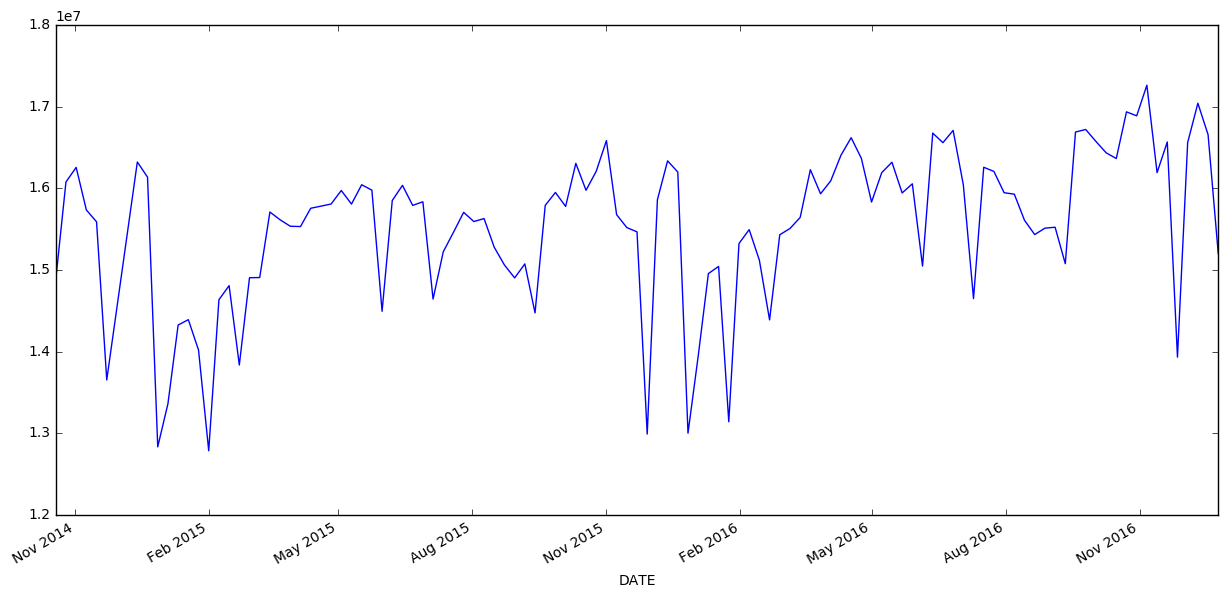

In [185]:
subway_man.ENTRIES_DIFF.plot(figsize=(15,7))

In [169]:
subway_man.ENTRIES_DIFF.describe()

count    1.150000e+02
mean     1.539464e+07
std      1.513168e+06
min      5.110264e+06
25%      1.505632e+07
50%      1.573691e+07
75%      1.619733e+07
max      1.726430e+07
Name: ENTRIES_DIFF, dtype: float64

In [170]:
subway_man.quantile(0.1)

ENTRIES_DIFF    13976875.6
dtype: float64

In [175]:
subway_man.ENTRIES_DIFF.mean() - 3*subway_man.ENTRIES_DIFF.std()

10855137.075668501

# ARIMA on Yellow pickups

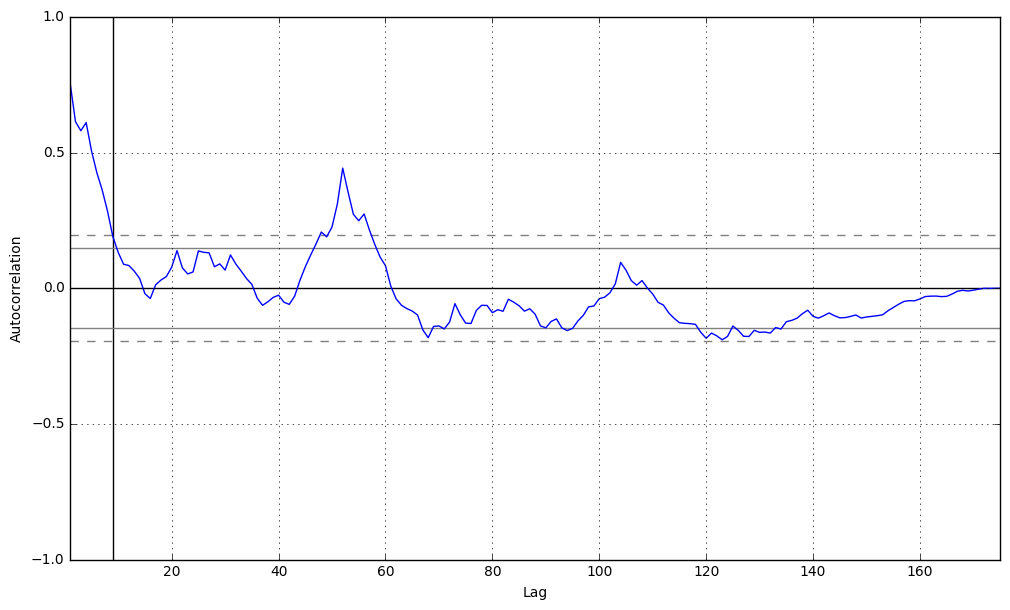

In [192]:
plt.figure(figsize=(12,7))
autocorrelation_plot(yp_upper_man.pickup_count)
plt.vlines(x= 9, ymin=-1, ymax=1)

                             ARIMA Model Results                              
Dep. Variable:         D.pickup_count   No. Observations:                  174
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2019.115
Method:                       css-mle   S.D. of innovations          26467.332
Date:                Sat, 22 Apr 2017   AIC                           4052.230
Time:                        20:47:00   BIC                           4074.343
Sample:                    01-27-2013   HQIC                          4061.201
                         - 05-22-2016                                         
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                 -291.9134   1070.053     -0.273      0.785     -2389.180  1805.353
ar.L1.D.pickup_count    -0.3253      0.076     -4.292      0.000        -0.474    -0.177
ar.L2.D.pick

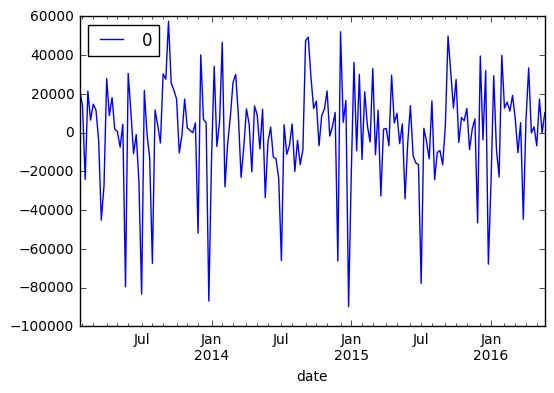

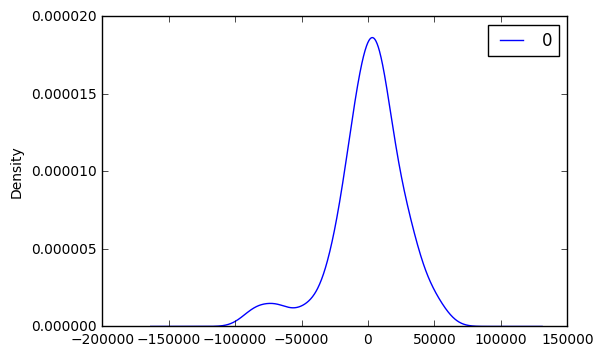

                  0
count    174.000000
mean      50.496717
std    26564.205568
min   -89871.309632
25%   -10354.973373
50%     3370.776578
75%    13862.485093
max    57426.346386


In [210]:
# fit model
model = ARIMA(yp_upper_man.pickup_count.astype(float), order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())